In [1]:
import rtde_control
import rtde_receive
import numpy as np
import sys
import yaml
from matplotlib import pyplot as plt
import SimpleITK as sitk
import pickle as pkl


import pyrealsense2 as rs
import cv2
import torch

import time
from collections import deque


from force_control import z_force_control

sys.path.append("../../")

from scripts.SurfaceContact.move import move_default_pose

from scripts.SurfaceContact.control import SurfaceContactControl
from scripts.USImageCV.models.unet import UNet
from scripts.USImageCV.utils.bunny import bunny_mask_predict, load_bunny_model,max_connected_area
%load_ext autoreload
%autoreload 2

# Connect to robot

In [2]:
# from recording_upload_server import CaptureServer

rtde_c = rtde_control.RTDEControlInterface("192.168.1.2")
rtde_r = rtde_receive.RTDEReceiveInterface("192.168.1.2")


# Connect to ultrasound image stream

In [3]:
ultrasound_vid = cv2.VideoCapture('/dev/video8')

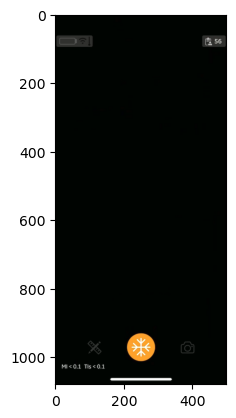

In [4]:

ret, frame = ultrasound_vid.read()		
plt.imshow(frame)

# Load pre-trained bunny segmentation model

In [5]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

trunk_model = load_bunny_model('../../scripts/USImageCV/model_weights/trunk_seg_model.pth',device)
vessel_model = load_bunny_model('../../scripts/USImageCV/model_weights/vessel_model.pth',device)

# Connect to RGB-D Camera

In [6]:
pipeline = rs.pipeline()
pipeline.start()


# Initialize surface finding controller

In [7]:
with open('../../config/pose_in_TCP_frame.yaml','r') as f:
    poses = yaml.safe_load(f)

    camera_2_tcp = poses['camera']
    probe_2_tcp = poses['probe']
    
body_color_rgb = (99, 55, 34)
body_hsv_rad = (50,50,200)
# rtde_c = rtde_r = []
sc = SurfaceContactControl(pipeline,rtde_c,rtde_r,
                           camera_2_tcp,probe_2_tcp,
                           body_color_rgb,body_hsv_rad)

In [8]:
move_default_pose(rtde_c)

405 260


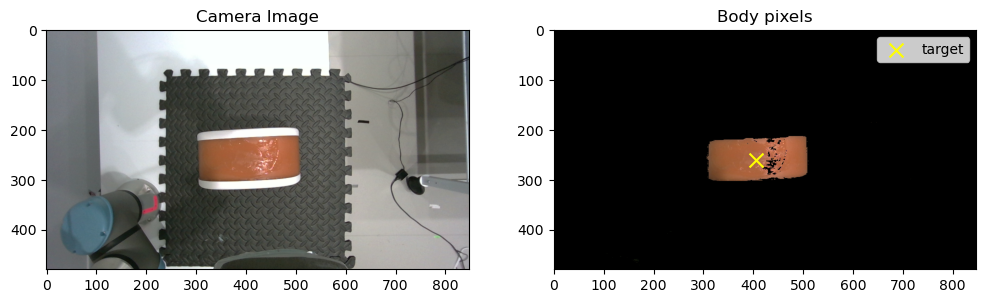

In [9]:
sc.fetchCameraStreamData()
fig = plt.figure(dpi=100,figsize = (12,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sc.showScene([ax1,ax2])


# Probe Control functions

In [10]:

def find_surface(sc):
    for _ in range(40):
        dist = sc.mainloop()
        dist_threshold = 0.005
        if dist<dist_threshold:
            break
    print("Arrived at above target location. Start descending.")

    sc.loc_normal_control(hover_height=0.20)
    # s = input("Find surface:?")

    if sc.getContact():
        print("Contact made.")


def find_object(model,area_threshold=5000):
    '''
        model: a neural network that detects the pixels of the object to find.
    '''

    def view_optim(start_pose,target_pose,search_vel=0.001,search_acc=0.1):
        # Optimize the view by traversing the robot from a start pose to a goal pose.

        # Move the TCP to the starting pose.
        rtde_c.moveL(start_pose,0.01,0.1) 
        
        # After reaching the starting pose, fire off the TCP to move towards the target_pose.
        # Setting asynchoronous=True allows the code to fly forward while the robot execute the motion independently.
        rtde_c.moveL(target_pose,search_vel,search_acc,asynchronous=True) 
        
        # In the asynchorous mode of moveL, we have to actively monitor the robot speed to determine whether the robot has stopped.
        speeds = []
        start_time = time.time()

        time.sleep(0.01) # This will allow the robot to start moving a little
        area_diff = deque(maxlen=3)

        max_area = 0
        optim_pose = []
        frames = []
        for i in range(1000):
            linear_tcp_speed = np.linalg.norm(rtde_r.getActualTCPSpeed()[:3])
            speeds.append(linear_tcp_speed)
            
            ret, frame = ultrasound_vid.read()	
            frames.append(frame)
            ###### Must record the curr_pose right after the image read and before the neural network inference.
            curr_pose = rtde_r.getActualTCPPose()	
            ######


            mask = bunny_mask_predict(model,frame,device)
            area = max_connected_area(mask)
            # print("area",area,"Time elapsed:",time.time()-start_time)
            area_diff.append(area)
            
            if area>max_area:
                max_area = area
                optim_pose = curr_pose
            
            if len(area_diff)>=3 and\
                np.min(area_diff)>4000 and \
                    area_diff[-1]-area_diff[-2]<0 and area_diff[-2]-area_diff[-3]<0:
                # If the area starts to consistently decline, stop the robot. 
                # print(list(area_diff))
                rtde_c.stopL() 
                # We can call stopL() to manually stop the robot during execution.
                # This is very useful pairing with the async move of moveL.

                # And move the robot to the optimal pose
                rtde_c.moveL(optim_pose,0.01,0.1)

                return max_area,frames
    
        if linear_tcp_speed<1e-4:
            return max_area,frames
    

    def y_direction_search():
        # y direction search has to be very careful, with low speed vel=0.001
        tcp_pose = rtde_r.getActualTCPPose()

        start_pose = rtde_c.poseTrans(tcp_pose,[0,-0.03,0,0,0,0])

        target_pose = rtde_c.poseTrans(tcp_pose,[0,+0.03,0,0,0,0])

        return view_optim(start_pose,target_pose,
                            search_vel = 0.01,
                            search_acc = 0.1)

    def x_direction_search():
        # x direction search can be more crude, with intermediate speed vel=0.01
        tcp_pose = rtde_r.getActualTCPPose()

        start_pose = rtde_c.poseTrans(tcp_pose,[-0.05,0,0,0,0,0])

        target_pose = rtde_c.poseTrans(tcp_pose,[+0.05,0,0,0,0,0])

        return view_optim(start_pose,target_pose,
                            search_vel = 0.01,
                            search_acc = 0.1)
    max_a = 0
    while True:
        y_direction_search(model)
        
        a,_ = x_direction_search(model)
        print('Max area',a)
        if a>=max_a:
            max_a = a
        if max_a>=area_threshold:
            break


def centralize_object(model):
    '''
        model: the neural network responsible for outputing the segmentation mask of the desired object.
    '''
    for i in range(20):
        ret, frame = ultrasound_vid.read()	
        mask = bunny_mask_predict(model,frame,device)
        z_c,x_c=np.mean(np.argwhere(mask),axis=0)

        # We have ensured that the x axis of TCP aligns with axis 1 of frame, and z axis of TCP aligns with axis[0] of frame.
        x_dir = x_c-frame.shape[1]//2
        print("Centralizing the object. Pixel distance remaining: ",np.linalg.norm(x_dir))

        if np.linalg.norm(x_dir)<20:
            break

        tcp_pose = rtde_r.getActualTCPPose()

        move_step = 1/500
        target_pose = rtde_c.poseTrans(tcp_pose,[move_step*np.sign(x_dir),0,0,0,0,0])


        rtde_c.moveL(target_pose,0.005,0.1)
    

def record_registration(model,n_samples):
    def record(start_pose,target_pose, n_waypoints = 50):
        start_loc = start_pose[:3]
        target_loc = target_pose[:3]
        waypoints = np.linspace(start_loc,target_loc,n_waypoints)
        waypoints = [list(w)+start_pose[3:] for w in waypoints]

        rtde_c.moveL(start_pose,0.01,0.1)
        # y direction search has to be very careful, with low speed vel=0.001
        tcp_pose = rtde_r.getActualTCPPose()
        start_pose = tcp_pose

        # In the asynchorous mode of moveL, we have to actively monitor the robot speed to determine whether the robot has stopped.
        speeds = []
        start_time = time.time()

        time.sleep(0.01) # This will allow the robot to start moving a little
        n_hist = 5
        areas = deque(maxlen=n_hist)

        poses=[]
        frames = []
        for w in waypoints:
            
            ret, frame = ultrasound_vid.read()
            frames.append(frame)
            ###### Must record the curr_pose right after the image read and before the neural network inference.
            curr_pose = rtde_r.getActualTCPPose()	
            poses.append(curr_pose)
            ######
            mask = bunny_mask_predict(model,frame,device)
            area = max_connected_area(mask)
            print("area",area,"Time elapsed:",time.time()-start_time)
            areas.append(area)
            if len(areas)>=n_hist and np.max(areas)<=2000:
                # If the area starts to consistently be small, stop the robot.
                # And move the robot to the start pose
                break
            rtde_c.moveL(w,0.01,0.1)
        rtde_c.moveL(start_pose,0.01,0.1)
        return frames,poses
    start_pose = rtde_r.getActualTCPPose()
    frames = []
    poses = []
    
    # Move and record in the feet direction
    target_pose = rtde_c.poseTrans(start_pose,[0,-0.03,0,0,0,0])
    f,p = record(start_pose,target_pose,n_waypoints = n_samples//2)
    
    # Make sure the order is from feet towards head
    f.reverse()
    p.reverse()

    frames+=f
    poses+=p
    # Move and record in the head direction
    target_pose = rtde_c.poseTrans(start_pose,[0,0.03,0,0,0,0])
    f,p = record(start_pose,target_pose,n_waypoints = n_samples//2)
    frames+=f
    poses+=p
    return frames,poses



def slice_matching(vessel_ct_slice,us_spacing):
    def search(y_step,n_iter = 20,lookback = 3):

        max_am = 0
        max_pos = rtde_r.getActualTCPPose()

        score_deque = deque(maxlen=lookback)
        for _ in range(n_iter):
            ret, frame = ultrasound_vid.read()
            pred_mask = bunny_mask_predict(vessel_model,frame,device)
            vessel_us_slice = pred_mask.T
            vessel_us_slice = sitk.GetImageFromArray(vessel_us_slice)
            vessel_us_slice.SetSpacing(us_spacing)

            t = time()
            _,am,_ = local_match(vessel_ct_slice,vessel_us_slice)
            print("Local match elapsed:",time()-t,"Match score:",am)

            curr_pose = rtde_r.getActualTCPPose()
            if am>max_am:
                max_pos = curr_pose
                max_am = am

            score_deque.append(am)
            if len(score_deque)>=lookback and np.max(score_deque)<100:
                break
            
            next_pose = rtde_c.poseTrans(curr_pose,[0,y_step,0,0,0,0])
            rtde_c.moveL(next_pose,0.01,0.1)
            centralize_object(vessel_model)
            
        return max_am, max_pos
    
    initial_pos = rtde_r.getActualTCPPose()

    step = 1/2000
    max_am,max_pos = search(vessel_ct_slice,step)

    rtde_c.moveL(initial_pos,0.01,0.1)

    step = -1/2000
    a,p = search(vessel_ct_slice,step)

    if a>max_am:
        max_pos = p
        max_am = a
    rtde_c.moveL(max_pos,0.01,0.1)


In [11]:
# Start the control pipeline
move_default_pose(rtde_c)

In [12]:
# Start the control pipeline
move_default_pose(rtde_c)
w0 = rtde_r.getActualTCPForce()# Record force zero

find_surface(sc)

target_force = 22
force_err_tolerance = 0.2
z_force_control(target_force,rtde_r,rtde_c,w0)

Arrived at above target location. Start descending.
Contact made.


Current force is:21.718339328680173:  Time elapsed=00:14

Target force reached.


True

In [13]:
find_object(trunk_model)
centralize_object(trunk_model)

Max area 5987.0
Centralizing the object. Pixel distance remaining:  49.44137695978188
Centralizing the object. Pixel distance remaining:  10.930174146014735


# Specify the target positions and views

In [ ]:
from local_match import local_match
from img_utils import get_slice_at,visualize_local_match, flip_imgc

In [84]:

with open('us_observations.pkl','rb') as fp:
    data = pkl.load(fp)
target_locs = data['CT_target_locs']
body_ct = sitk.ReadImage('./nifty/CT_phantom_regular.nii.gz')
body_ct = flip_img(body_ct,[True,False,False])
vessel_ct = sitk.ReadImage('./nifty/vessel_ct.nii.gz')
vessel_ct = flip_img(vessel_ct,[True,False,False])

loc = target_locs[3]

pix = body_ct.TransformPhysicalPointToIndex(loc)
# Standardize the resolution for US and CT vessel slice images.b
vessel_ct_slice = get_slice_at(vessel_ct,pix)
vessel_ct_slice = sitk.GetImageFromArray(vessel_ct_slice)
vessel_ct_slice.SetSpacing(vessel_ct.GetSpacing()[:2])

with open('../../config/us_spacing.yaml') as fp:
    sp = yaml.safe_load(fp)

# Spacing Units are mm. 
us_spacing = (sp['xspacing'], sp['yspacing'])

slice_matching(vessel_ct_slice,us_spacing)


Local match elapsed: 0.2811300754547119 Match score: 539.50146
Centralizing the object. Pixel distance remaining:  18.08511461456618
Local match elapsed: 0.21010041236877441 Match score: 543.6474
Centralizing the object. Pixel distance remaining:  4.5634956759217005
Local match elapsed: 0.1816396713256836 Match score: 547.7755
Centralizing the object. Pixel distance remaining:  0.7147717004199308
Local match elapsed: 0.20440435409545898 Match score: 545.6049
Centralizing the object. Pixel distance remaining:  4.744831092531911
Local match elapsed: 0.19010472297668457 Match score: 539.61505
Centralizing the object. Pixel distance remaining:  8.83982733812951
Local match elapsed: 0.21077871322631836 Match score: 528.1448
Centralizing the object. Pixel distance remaining:  9.254845998335128
Local match elapsed: 0.27345895767211914 Match score: 530.178
Centralizing the object. Pixel distance remaining:  8.65470905818836
Local match elapsed: 0.19574308395385742 Match score: 532.01245
Centra

Local match elapsed: 0.25635242462158203 Match score: 546.56506


<Figure size 1500x600 with 0 Axes>

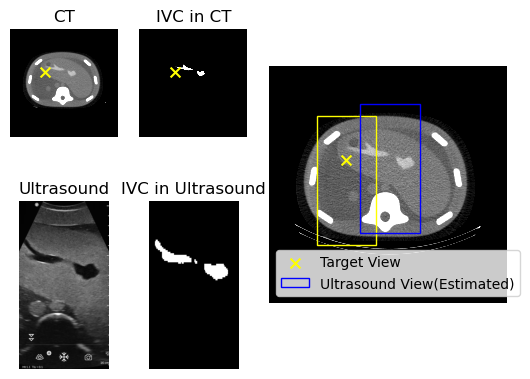

In [86]:

ret, frame = ultrasound_vid.read()
pred_mask = bunny_mask_predict(vessel_model,frame,device)
vessel_us_slice = pred_mask.T
vessel_us_slice = sitk.GetImageFromArray(vessel_us_slice)
vessel_us_slice.SetSpacing(us_spacing)

t = time()
pos,am,box = local_match(vessel_ct_slice,vessel_us_slice)
print("Local match elapsed:",time()-t,"Match score:",am)

visualize_local_match(body_ct,vessel_ct,pix,pred_mask, pos)
   

In [87]:
move_default_pose(rtde_c)

# Clean up

In [88]:
ultrasound_vid.release()
pipeline.stop()

# Useful Scripts

In [4]:
# Script for saving default pose
with open('../../config/default_pose.yaml','w') as f:
    yaml.safe_dump({'default_pose':rtde_r.getActualTCPPose()},f)